# **Delivery Time Estimation**

#### **Problem**

The business wants to evaluate the Estimated Delivery Time on the basis of
- What they are ordering?
- From Where they are ordering
- The availibilty of Delivery Partners
- etc

I'll explore the data to find hidden stories and since this is a Regression task, I'll use Neural Networks to estimate the same.

# **Data Initialization**

In [1]:
# Importing required libraries
from pyspark.sql import SparkSession
from numba import jit

In [2]:
# Pyspark Java Setup

import os

# Set the JAVA_HOME environment variable
os.environ['JAVA_HOME'] = '/home/studio-lab-user/.conda/envs/delivery_time_torch'
os.environ['PATH'] = os.environ['JAVA_HOME'] + '/bin:' + os.environ['PATH']

In [3]:
# Initiallizing Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/28 09:03:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Adjust Spark session settings to improve display
spark.conf.set("spark.sql.repl.eagerEval.maxNumRows", 20)
spark.conf.set("spark.sql.repl.eagerEval.truncate", 100)
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [5]:
# Investigating Dataset
df = spark.read.csv('../data/raw/data.csv', header=True, inferSchema=True)
df.limit(5)

market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0
2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0
3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NULL,1.0,1,1900,1,1900,1900,1.0,0.0,0.0
3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NULL,1.0,6,6900,5,600,1800,1.0,1.0,2.0
3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NULL,1.0,3,3900,3,1100,1600,6.0,6.0,9.0


In [6]:
# Shape of the dataset

print(f"Shape of DataFrame: (rows: {df.count()}, columns: {len(df.columns)})")

Shape of DataFrame: (rows: 197428, columns: 14)


**Observe**
- We have 14 features and almost 200K datapoints
- Data seems to be small

In [7]:
# Datatypes Info
df.printSchema()

root
 |-- market_id: double (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- actual_delivery_time: timestamp (nullable = true)
 |-- store_id: string (nullable = true)
 |-- store_primary_category: string (nullable = true)
 |-- order_protocol: double (nullable = true)
 |-- total_items: integer (nullable = true)
 |-- subtotal: integer (nullable = true)
 |-- num_distinct_items: integer (nullable = true)
 |-- min_item_price: integer (nullable = true)
 |-- max_item_price: integer (nullable = true)
 |-- total_onshift_partners: double (nullable = true)
 |-- total_busy_partners: double (nullable = true)
 |-- total_outstanding_orders: double (nullable = true)



In [8]:
# Filtering columns on the basis of Data Types

from pyspark.sql.types import IntegerType, StringType, NumericType, TimestampType

continuous_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]
categorical_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]
temporal_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, TimestampType)]

In [9]:
# Null Values

from pyspark.sql.functions import col, count, when

df.select([count(when(col(c).isNull(),c)).alias(c) for c in df.columns]).toPandas().transpose()/df.count() * 100

,0
market_id,0.499929
created_at,0.000000
actual_delivery_time,0.003546
store_id,0.000000
store_primary_category,2.411006
order_protocol,0.503981
total_items,0.000000
subtotal,0.000000
num_distinct_items,0.000000
min_item_price,0.000000


**Observe**
- Need to treat many Null Values, Cannot drop

In [10]:
# Statistics Summary
df.select(*continuous_cols).summary().toPandas().transpose()

24/05/28 09:04:12 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/05/28 09:04:14 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


,0,1,2,3,4,5,6,7
summary,count,mean,stddev,min,25%,50%,75%,max
market_id,196441,2.978706074597462,1.5248667244506284,1.0,2.0,3.0,4.0,6.0
order_protocol,196433,2.8823517433425137,1.5037712034995787,1.0,1.0,3.0,4.0,7.0
total_items,197428,3.196390582896043,2.6665460635998874,1,2,3,4,411
subtotal,197428,2682.331401827502,1823.0936878547845,0,1400,2200,3395,27100
num_distinct_items,197428,2.6707913771096297,1.630255241338155,1,1,2,3,20
min_item_price,197428,686.2184695180015,522.0386476914737,-86,299,595,949,14700
max_item_price,197428,1159.5886297789573,558.4113766592675,0,800,1095,1395,14700
total_onshift_partners,181166,44.808093130057514,34.526783476213446,-4.0,17.0,37.0,65.0,171.0
total_busy_partners,181166,41.739746972389966,32.145732718031816,-5.0,15.0,34.0,62.0,154.0


**Observe**
- Higher Outliers observed in Subtotals, indicating the field is affected by extremes
- Also thorough investigation is required for the Negative values observed in the Item price, orders and partners

In [11]:
# Uniuqe Values Observed

from pyspark.sql.functions import countDistinct

df.agg(*(countDistinct(c).alias(c) for c in df.columns)).toPandas().transpose()

,0
market_id,6
created_at,180985
actual_delivery_time,178110
store_id,6743
store_primary_category,74
order_protocol,7
total_items,57
subtotal,8368
num_distinct_items,20
min_item_price,2312


In [12]:
# Analysze Value counts for Low Cardinal features

from pyspark.sql.functions import lit,col,round

low_cardinal = ["market_id", "order_protocol"]
for c in low_cardinal:
    display(df.groupby(c).count().withColumn( "normalized_count", round(col("count")/lit(df.count()) * 100,2) ))

market_id,count,normalized_count
NULL,987,0.5
1.0,38037,19.27
4.0,47599,24.11
3.0,23297,11.8
2.0,55058,27.89
6.0,14450,7.32
5.0,18000,9.12


order_protocol,count,normalized_count
7.0,19,0.01
NULL,995,0.5
1.0,54725,27.72
4.0,19354,9.8
3.0,53199,26.95
2.0,24052,12.18
6.0,794,0.4
5.0,44290,22.43


**Observe**
- marked_id of 2 dominates the market
- order_protocol 1 & 3 are most common protocols used to plkace order

# **Exploratory Data Analysis**

In [13]:
# Assigning Discrete Numerical Cols to Categorical cols
discrete_cols = [ "market_id","order_protocol","num_distinct_items"]

for c in discrete_cols:
    continuous_cols.remove(c)
    categorical_cols.append(c)

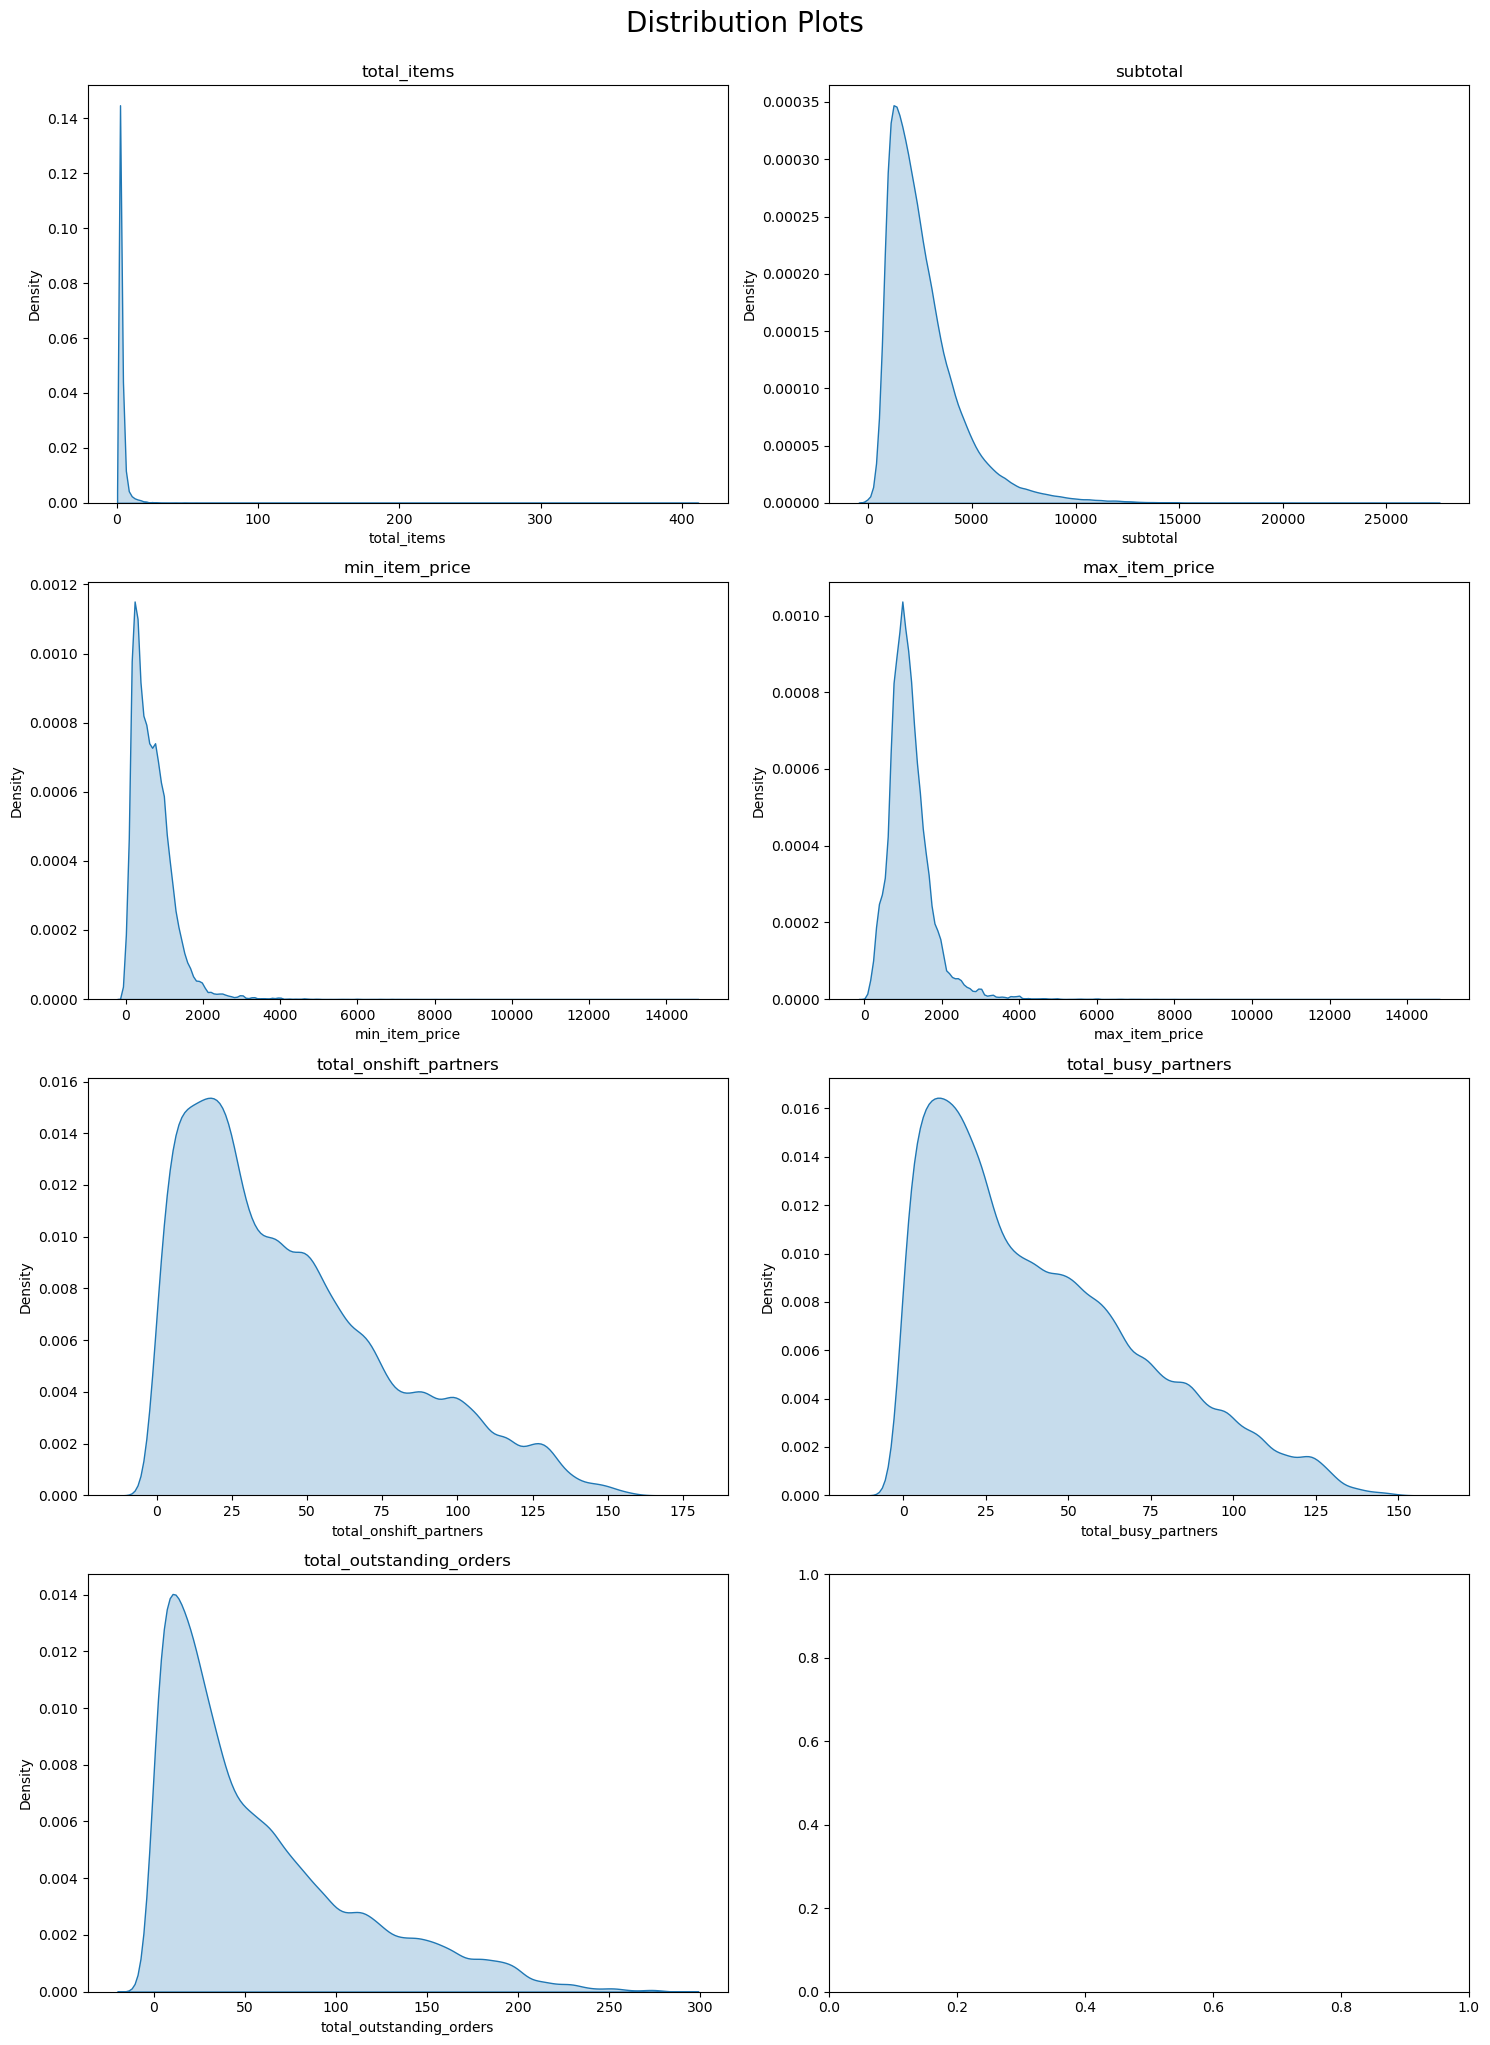

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

pandas_df = df.toPandas()

nrows = (len(continuous_cols) // 2) + (len(continuous_cols) % 2)

fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15, 5 * nrows))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through each continuous column to create distribution plots
for i, feature in enumerate(continuous_cols):
    sns.kdeplot(data=pandas_df, x=feature, fill=True, ax=axes[i] )
    axes[i].set_title(feature)

# Adjust layout
plt.tight_layout()
plt.suptitle("Distribution Plots", y=1.02, fontsize=20)
plt.show()

**Observe**
- All the distribution seems to be a part od **Log Normal** Distribution
- totsl_items is highly skewed indicating large presence of outliers